## Physionet (Blood Pressure in Salt-Sensitive Dahl Rats)
### RNN Predict

In [2]:
import pandas as pd

df = pd.read_csv('data.csv') # csv 데이터 불러옴
data_size = 12000 # data 사이즈 설정

In [3]:
df.head()

,row_num,_id,db_id,rcrd_id,signal
0,0,602b94114b50caecb7a3e315,bpssrat,ssbn13hs01,138.01
1,1,602b94114b50caecb7a3e316,bpssrat,ssbn13hs01,137.23
2,2,602b94214b50caecb7a3e317,bpssrat,ssbn13hs01,136.18
3,3,602b94214b50caecb7a3e318,bpssrat,ssbn13hs01,134.74
4,4,602b94214b50caecb7a3e319,bpssrat,ssbn13hs01,132.21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   row_num  12000 non-null  int64  
 1   _id      12000 non-null  object 
 2   db_id    12000 non-null  object 
 3   rcrd_id  12000 non-null  object 
 4   signal   12000 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 468.9+ KB


In [5]:
df.describe()

,row_num,signal
count,12000.00000,12000.000000
mean,5999.50000,143.024922
std,3464.24595,9.055939
min,0.00000,123.590000
25%,2999.75000,135.580000
50%,5999.50000,141.170000
75%,8999.25000,150.310000
max,11999.00000,168.670000


In [6]:
series = df['signal'].values

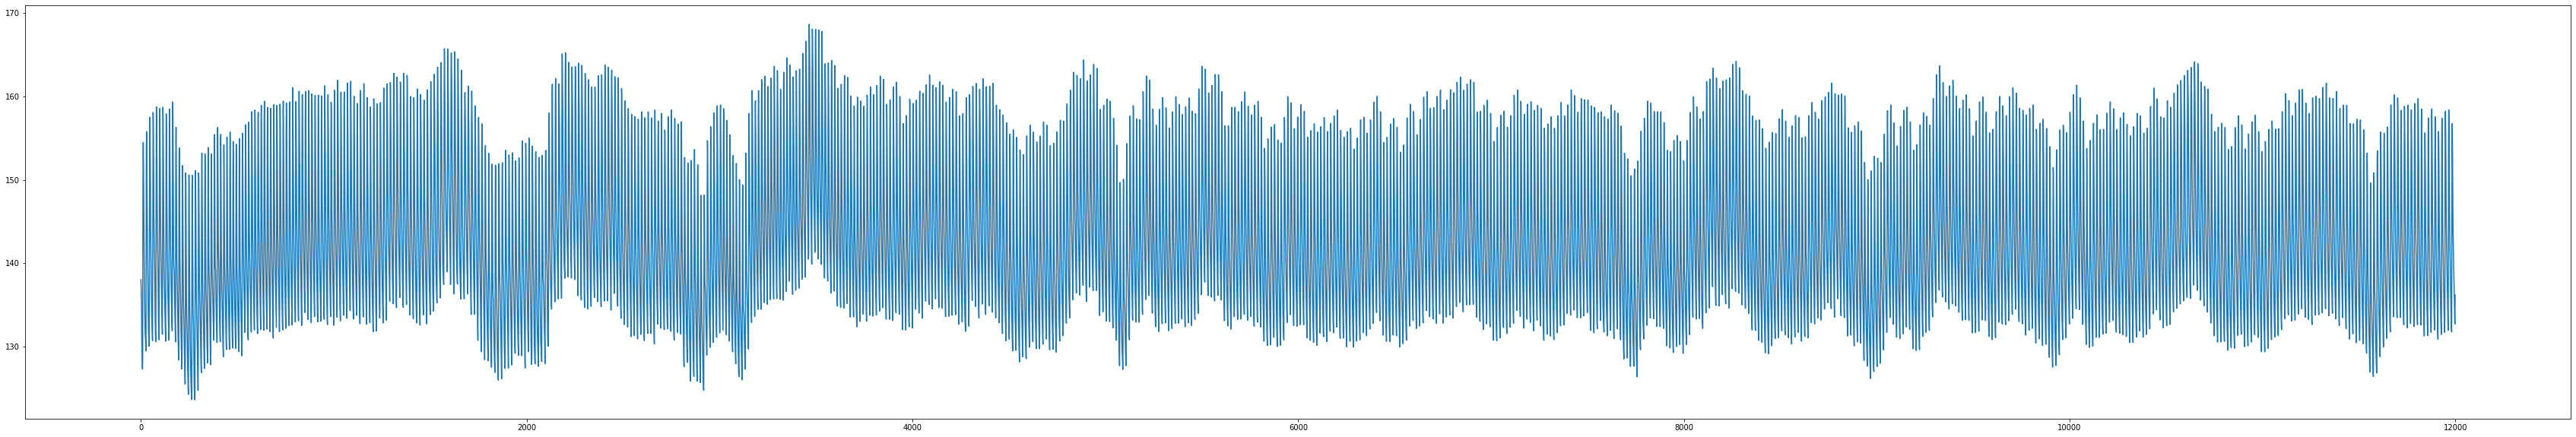

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (60,10)
plt.plot(series)
plt.show()

In [8]:
# 전체 데이터셋에서 훈련 데이터셋은 75%, 테스트 데이터셋는 25%로 나눌 것
# 또한 훈련 데이터셋을 다시 훈련 데이터셋 75%, 검증 데이터셋 25%로 나눌 것

train_end_index = int(data_size*0.75*0.75) 
# 훈련 데이터 75%의 75% 인덱스 설정
val_end_index = int(data_size*0.75) # 검증 데이터 75%의 인덱스 설정
train = series[:train_end_index] # 훈련 데이터 나누기
val = series[train_end_index:val_end_index] # 검증 데이터 나누기
test = series[val_end_index:] # 테스트 데이터 나누기

In [9]:
print(train.shape) # 훈련 데이터
print(val.shape) # 검증 데이터
print(test.shape) # 테스트 데이터

(6750,)
(2250,)
(3000,)


In [10]:
lookback = 50 # 과거의 데이터 고려 정도
forward = 1 # 어느 데이터를 예측할것인지

In [11]:
import numpy as np

def generate_series(data, lookback, forward): # 데이터 세트 구성 함수
    size = data.shape[0]
    input = [] # input list 선언
    target = [] # target list 선언
    for i in range(lookback-1,size-forward):
        tmp_input = []
        for j in range(i-lookback,i):
            tmp_input.append(data[j])
        input.append(tmp_input) # input 데이터 생성
        target.append(data[i+forward]) # target 데이터 생성
    return np.array(input),np.array(target) # 생성된 데이터 세트 반환


In [12]:
train_input, train_target = generate_series(train,lookback,forward) 
# 훈련 데이터 세트 생성
val_input, val_target = generate_series(val,lookback,forward) 
# 검증 데이터 세트 생성
test_input, test_target = generate_series(test,lookback,forward) 
# 테스트 데이터 생성


In [13]:
# 데이터 세트의 개수를 파악하기 위해 2차원 배열로 변경

train_target = train_target.reshape(-1,1)
val_target = val_target.reshape(-1,1)
test_target = test_target.reshape(-1,1)

print(train_input.shape) # train input 테이블 형태 출력
print(train_target.shape) # train target 테이블 형태 출력


(6700, 50)
(6700, 1)


In [14]:
from sklearn.preprocessing import MinMaxScaler # Scaler 처리

input_scaler = MinMaxScaler()
train_input_scaled = input_scaler.fit_transform(train_input) 
# 훈련 데이터 input sclaer 처리
val_input_scaled = input_scaler.transform(val_input) 
# 검증 데이터 input scaler 처리
test_input_scaled = input_scaler.transform(test_input) 
# 테스트 데이터 scaler 처리


In [15]:
train_input_scaled = train_input_scaled.reshape(-1, lookback,1) # 3차원으로 변경
val_input_scaled = val_input_scaled.reshape(-1, lookback,1) # 3차원으로 변경
test_input_scaled = test_input_scaled.reshape(-1, lookback,1) # 3차원으로 변경

print(train_input_scaled.shape)
print(val_input_scaled.shape)
print(test_input_scaled.shape)


(6700, 50, 1)
(2200, 50, 1)
(2950, 50, 1)


In [16]:
# simpleRNN 사용하여 시계열 데이터 예측

from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(20, return_sequences=True, input_shape=train_input_scaled.shape[1:]))
model.add(SimpleRNN(20, return_sequences=True))
model.add(SimpleRNN(1))


In [17]:
# EarlyStopping 기능을 사용하여 학습
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss',patience=5, 
mode='min', restore_best_weights=True)

model.compile(loss='mse', optimizer='adam')
model.fit(train_input_scaled,train_target,epochs=100,\
          validation_data=(val_input_scaled,val_target), \
callbacks=[early_stopping])


Epoch 1/100
210/210 [==============================] - 8s 29ms/step - loss: 20329.9551 - val_loss: 20161.1016
Epoch 2/100
210/210 [==============================] - 5s 26ms/step - loss: 20323.4023 - val_loss: 20160.9551
Epoch 3/100
210/210 [==============================] - 5s 23ms/step - loss: 20323.3223 - val_loss: 20160.8945
Epoch 4/100
210/210 [==============================] - 5s 22ms/step - loss: 20323.2773 - val_loss: 20160.8770
Epoch 5/100
210/210 [==============================] - 5s 22ms/step - loss: 20323.2676 - val_loss: 20160.8594
Epoch 6/100
210/210 [==============================] - 5s 22ms/step - loss: 20323.2559 - val_loss: 20160.8535
Epoch 7/100
210/210 [==============================] - 5s 22ms/step - loss: 20323.2461 - val_loss: 20160.8457
Epoch 8/100
210/210 [==============================] - 4s 21ms/step - loss: 20323.2461 - val_loss: 20160.8438
Epoch 9/100
210/210 [==============================] - 5s 22ms/step - loss: 20323.2383 - val_loss: 20160.8418
Epoch 10/1

In [18]:
model.evaluate(test_input_scaled, test_target)

93/93 [==============================] - 1s 6ms/step - loss: 20189.4766


20189.4765625

In [19]:
test_target_pred = model.predict(test_input_scaled)

# 예측 정도를 확인하기 위해 MSE 점수를 계산

from sklearn.metrics import mean_squared_error
print(mean_squared_error(test_target, test_target_pred)) # MSE 출력


20189.480069636167


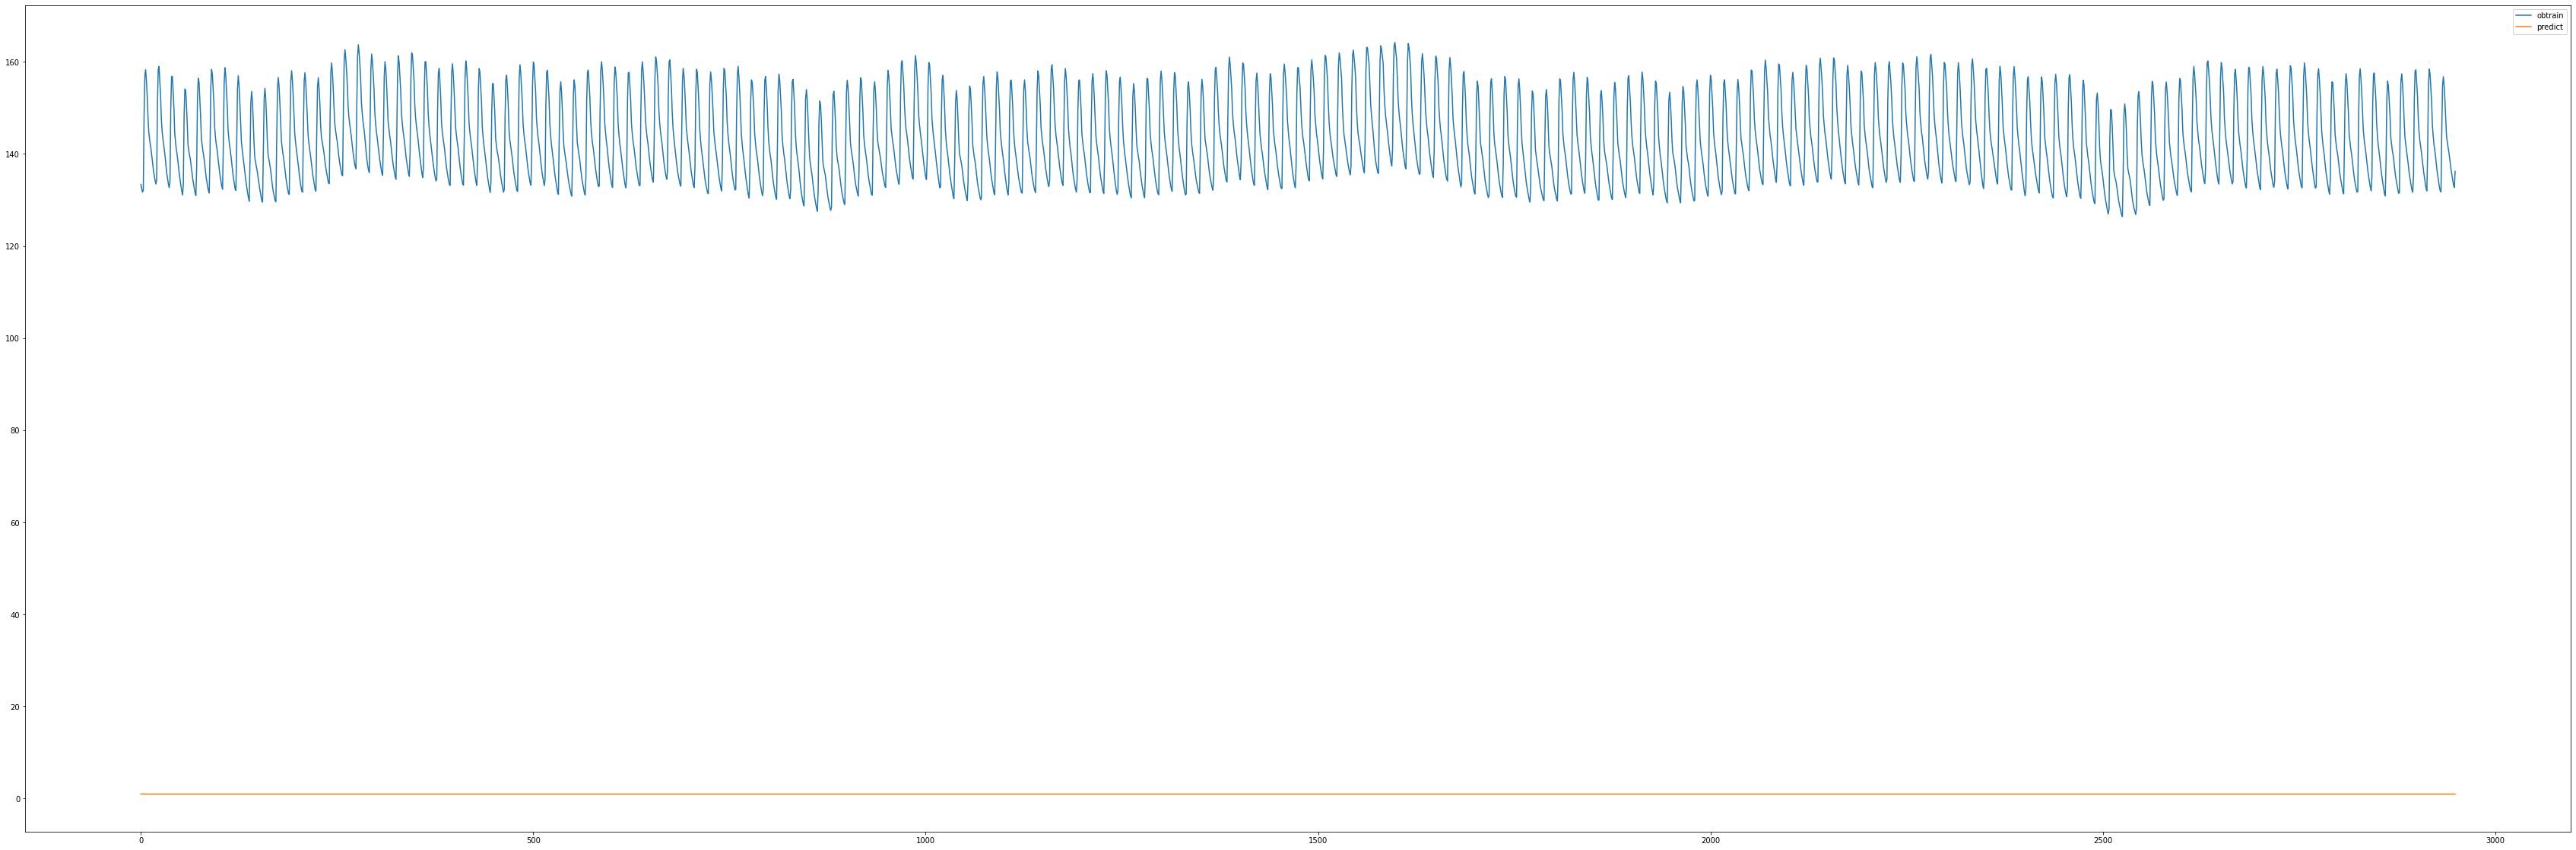

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (60,20)
plt.plot(test_target)
plt.plot(test_target_pred)
plt.legend(['obtrain', 'predict'])
plt.show()